In [1]:
import os
from torch.utils.data import DataLoader
from trajdata import AgentBatch, UnifiedDataset

In [2]:
import torch
from torch import Tensor

torch.manual_seed(0xDEADBEEF)

In [3]:
dataset = UnifiedDataset(
    desired_data=["eupeds_eth","eupeds_hotel","eupeds_univ","eupeds_zara1","eupeds_zara2" ],
    data_dirs={  # Remember to change this to match your filesystem!
        "eupeds_eth": "../data/eth",
        "eupeds_hotel": "../data/eth",
        "eupeds_univ": "../data/eth",
        "eupeds_zara1": "../data/eth",
        "eupeds_zara2": "../data/eth",
    },
    desired_dt = 0.1,
    state_format = 'x,y',
    obs_format= 'x,y',
    centric = "scene",
    history_sec = (0.8,0.8),
    future_sec = (0.8,0.8),
    standardize_data =False,
)

In [4]:
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=dataset.get_collate_fn(),
    num_workers=os.cpu_count(), # This can be set to 0 for single-threaded loading, if desired.
)

In [5]:
data_iter = iter(dataloader)
batch = next(data_iter) 

In [6]:
print("Ключи батча:")

for k, v in vars(batch).items():
    if torch.is_tensor(v):
        print(f"{k:25s} -> tensor {tuple(v.shape)} dtype={v.dtype}")
    elif isinstance(v, dict):
        print(f"{k:25s} -> dict ({list(v.keys())[:5]} ...)")
    elif isinstance(v, list):
        print(f"{k:25s} -> list len={len(v)}")
    else:
        print(f"{k:25s} -> {type(v)}")

Ключи батча:
data_idx                  -> tensor (64,) dtype=torch.int32
scene_ts                  -> tensor (64,) dtype=torch.int32
dt                        -> tensor (64,) dtype=torch.float32
num_agents                -> tensor (64,) dtype=torch.int64
agent_type                -> tensor (64, 52) dtype=torch.int64
centered_agent_state      -> tensor (64, 2) dtype=torch.float32
agent_names               -> list len=64
agent_hist                -> tensor (64, 52, 9, 2) dtype=torch.float32
agent_hist_extent         -> tensor (64, 52, 9, 3) dtype=torch.float32
agent_hist_len            -> tensor (64, 52) dtype=torch.int64
agent_fut                 -> tensor (64, 52, 8, 2) dtype=torch.float32
agent_fut_extent          -> tensor (64, 52, 8, 3) dtype=torch.float32
agent_fut_len             -> tensor (64, 52) dtype=torch.int64
robot_fut                 -> <class 'NoneType'>
robot_fut_len             -> tensor (64,) dtype=torch.int64
map_names                 -> <class 'NoneType'>
maps       

In [7]:
batch

SceneBatch(data_idx=tensor([126913,  64303, 113898,  46100,   7623,  56024, 109852, 113603,  25063,
         31336,  16742,  40066, 137536,  71393,  87112,  28374,  33120,  66579,
         68922,  38163,  72250, 102935, 123688,  99733, 118844,  54945,  74106,
        137816,   2410,  26070,  67950, 106788, 105705,   6871,  39882,  52826,
        100144,  10984,  24334, 135270,  64856,  98552, 127250,  51260,  42052,
         74684,  95917, 102424,  47868,  24405,  58695,  48123, 134568, 131671,
          6572, 100170,  74415, 133134,   6985,  29542,  85190,  75640,   8290,
         35339], dtype=torch.int32), scene_ts=tensor([ 954, 4506, 2932,  847, 1406,  588, 2362, 2637, 1625,   49,  587,  210,
        2447,  322,  329, 1890, 3090, 1663, 1196, 1652, 1179, 1781,  111,   71,
        1967, 6444,  725, 2727, 3682, 3219,  209,  133,  797,  560,   26, 2759,
         482, 1957,  236,  166, 5343,  291, 1291,  466, 2207, 1395,   38, 1217,
         665,  346,  149,   94,  393,  747,  261,  508

In [8]:
def build_model_batch(batch, memory=3, dim=2):
    agent_hist = batch.agent_hist          # (B, A, H, 2)
    agent_fut  = batch.agent_fut           # (B, A, F, 2)
    hist_len   = batch.agent_hist_len      # (B, A)
    fut_len    = batch.agent_fut_len       # (B, A)
    dt         = batch.dt                  # (B,)

    B, A, H, _ = agent_hist.shape
    _, _, F, _ = agent_fut.shape

    # Маска: у кого есть хотя бы memory+1 исторических и ≥1 будущего шага
    valid = (hist_len >= (memory + 1)) & (fut_len >= 1)

    x0_list, x0cls_list, x1_list, t0_list, t1_list = [], [], [], [], []

    for b in range(B):
        dtb = dt[b].item()
        for a in range(A):
            if not valid[b, a]:
                continue

            t0_idx = int(hist_len[b, a].item()) - 1
            start = t0_idx - (memory - 1)

            # Извлекаем значения
            x0 = agent_hist[b, a, t0_idx, :dim]
            xhist = agent_hist[b, a, start:t0_idx+1, :dim].reshape(-1)
            x1 = agent_fut[b, a, 0, :dim]

            # Проверка на NaN
            if (
                torch.isnan(x0).any() or
                torch.isnan(x1).any() or
                torch.isnan(xhist).any()
            ):
                continue  # пропускаем невалидного агента

            # Тайминги
            t0 = torch.tensor(0.0, dtype=agent_hist.dtype)
            t1 = torch.tensor(dtb, dtype=agent_hist.dtype)

            x0_list.append(x0)
            x0cls_list.append(xhist)
            x1_list.append(x1)
            t0_list.append(t0)
            t1_list.append(t1)

    if len(x0_list) == 0:
        return None

    x0_values  = torch.stack(x0_list, dim=0)
    x0_classes = torch.stack(x0cls_list, dim=0)
    x1_values  = torch.stack(x1_list, dim=0)
    times_x0   = torch.stack(t0_list, dim=0)
    times_x1   = torch.stack(t1_list, dim=0)

    return x0_values, x0_classes, x1_values, times_x0, times_x1

def __x_processing__(x0, x1, t0, t1):
        # squeeze xs (prevent mismatch)
        dim = 2
        sigma = 0.5
        x0 = x0.squeeze(0)
        x1 = x1.squeeze(0)
        t0 = t0.squeeze()
        t1 = t1.squeeze()

        t = torch.rand(x0.shape[0],1).to(x0.device)
        mu_t = x0 * (1 - t) + x1 * t
        data_t_diff = (t1 - t0).unsqueeze(1)
        x = mu_t + sigma * torch.randn(x0.shape[0], dim).to(x0.device)

        ut = (x1 - x0) / (data_t_diff + 1e-4)
        t_model = t * data_t_diff + t0.unsqueeze(1)
        futuretime = t1 - t_model

        return x, ut, t_model, futuretime, t

def __convert_tensor__(tensor):
        return tensor.to(torch.float32)

In [9]:
x0, x0_class, x1, x0_time, x1_time = build_model_batch(batch, memory=4, dim=2)
x0, x0_class, x1, x0_time, x1_time = __convert_tensor__(x0), __convert_tensor__(x0_class), __convert_tensor__(x1), __convert_tensor__(x0_time), __convert_tensor__(x1_time)
x, ut, t_model, futuretime, t = __x_processing__(x0, x1, x0_time, x1_time)

In [10]:
in_tensor = torch.cat([x,x0_class, t_model], dim = -1)
in_tensor.shape

torch.Size([723, 11])

In [11]:
import sys
sys.path.append("../src/")
from models.tfm_mlp import MLP_conditional_memory

/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/lightning_utilities/core/imports.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [12]:
flow_model = MLP_conditional_memory(dim=2, 
                                              w=256, 
                                              time_varying=True, 
                                              conditional=True, 
                                              treatment_cond=0,
                                              memory=4,
                                              clip = 1e-2)

In [13]:
xt = flow_model.forward_train(in_tensor)

In [14]:
xt.shape

torch.Size([723, 11])

In [15]:
batch = next(data_iter) 
# x0_values, x0_classes, x1_values, times_x0, times_x1 = build_model_batch(batch, memory=3, dim=2)

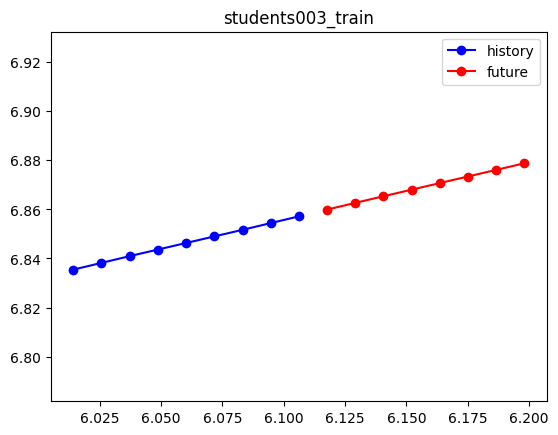

In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np

idx = 0
agent_idx = 0

hist = batch.agent_hist[idx, agent_idx, :, :2].cpu().numpy()
fut = batch.agent_fut[idx, agent_idx, :, :2].cpu().numpy()

plt.plot(hist[:,0], hist[:,1], 'bo-', label='history')
plt.plot(fut[:,0], fut[:,1], 'ro-', label='future')
plt.legend()
plt.axis('equal')
plt.title(batch.scene_ids[idx])
plt.show()


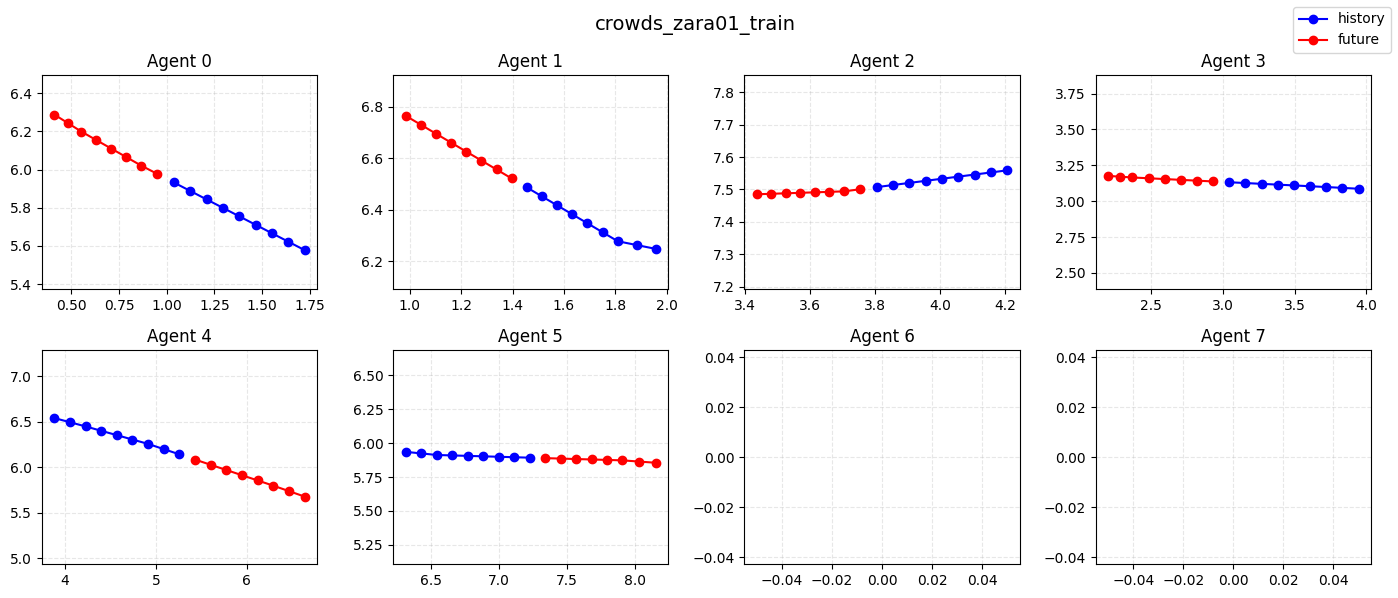

In [17]:
scene_idx = 4              # Берём первую сцену из батча
num_agents_to_show = 8     # Сколько агентов визуализировать (первые 8)
nrows, ncols = 2, 4        # Размер сетки

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 6))
axes = axes.flatten()

for i in range(num_agents_to_show):
    ax = axes[i]
    
    hist = batch.agent_hist[scene_idx, i, :, :2].cpu().numpy()
    fut = batch.agent_fut[scene_idx, i, :, :2].cpu().numpy()
    
    # маска валидных точек (если есть NaN или padding)
    hist_valid = ~np.isnan(hist[:, 0])
    fut_valid = ~np.isnan(fut[:, 0])

    ax.plot(hist[hist_valid, 0], hist[hist_valid, 1], 'bo-', label='history')
    ax.plot(fut[fut_valid, 0], fut[fut_valid, 1], 'ro-', label='future')

    ax.set_title(f"Agent {i}")
    ax.axis("equal")
    ax.grid(True, linestyle='--', alpha=0.3)

# Добавим общую легенду и заголовок
fig.suptitle(batch.scene_ids[scene_idx], fontsize=14)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

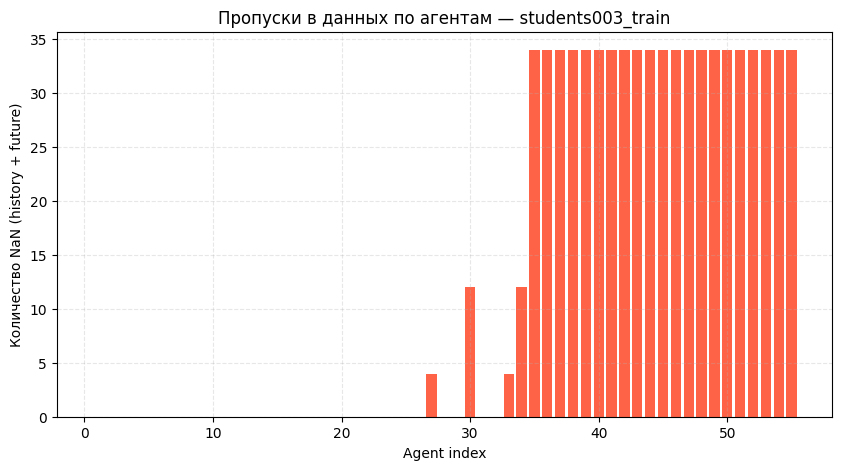

In [18]:
# Берём первую сцену из батча
scene_idx = 0

# Извлекаем историю и будущее всех агентов
hist = batch.agent_hist[scene_idx].cpu().numpy()  # (52, H, 3)
fut  = batch.agent_fut[scene_idx].cpu().numpy()   # (52, F, 3)

# Считаем количество NaN по каждому агенту (в координатах x,y,yaw)
nan_hist = np.isnan(hist).sum(axis=(1, 2))
nan_fut  = np.isnan(fut).sum(axis=(1, 2))
nan_total = nan_hist + nan_fut

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, len(nan_total)+1), nan_total, color='tomato')
plt.xlabel("Agent index")
plt.ylabel("Количество NaN (history + future)")
plt.title(f"Пропуски в данных по агентам — {batch.scene_ids[scene_idx]}")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


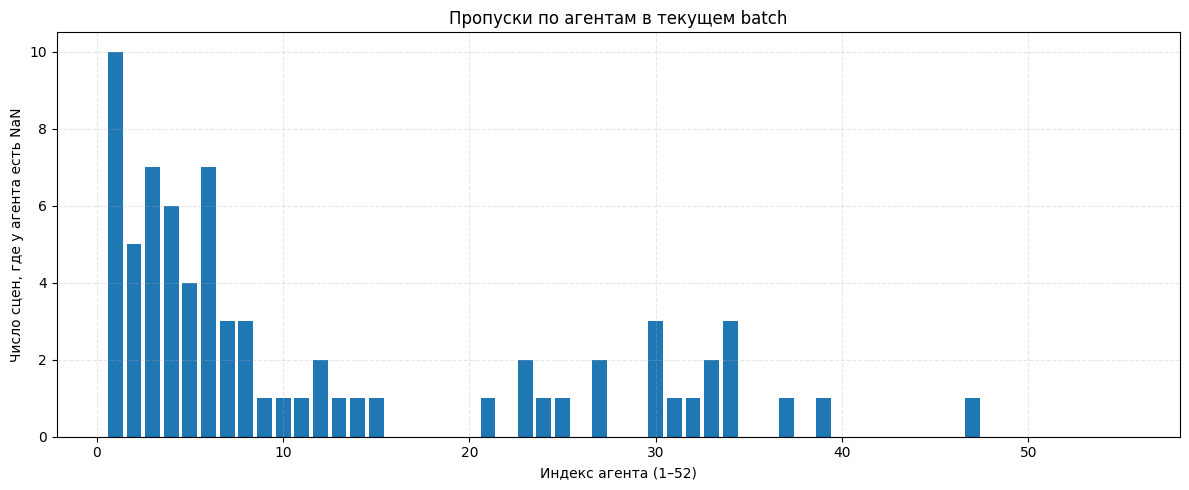

In [19]:

# Берём всё из текущего batch
hist = batch.agent_hist.cpu().numpy()    # (B, A=52, H, 3)
fut  = batch.agent_fut.cpu().numpy()     # (B, A=52, F, 3)
num_agents = batch.num_agents.cpu().numpy()  # (B,)

B, A = hist.shape[0], hist.shape[1]
nan_counts = np.zeros(A, dtype=int)  # счётчик по агентам (индекс 0..51)

for s in range(B):                         # цикл по сценам
    amax = int(num_agents[s])              # реальное число агентов в сцене
    if amax == 0:
        continue

    # берём только существующих агентов и только координаты x,y
    h = hist[s, :amax, :, :2]
    f = fut[s, :amax, :, :2]

    # есть ли NaN у агента в истории или будущем (хоть один)
    has_nan = np.isnan(h).any(axis=(1, 2)) | np.isnan(f).any(axis=(1, 2))  # (amax,)
    nan_counts[:amax] += has_nan.astype(int)

# Построим гистограмму: X — агенты (1..52), Y — число сцен с NaN у данного индекса агента
x = np.arange(1, A + 1)
plt.figure(figsize=(12, 5))
plt.bar(x, nan_counts)
plt.xlabel("Индекс агента (1–52)")
plt.ylabel("Число сцен, где у агента есть NaN")
plt.title("Пропуски по агентам в текущем batch")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm  # красиво покажет прогресс

# Инициализируем массив под счётчики
A = 52  # максимум агентов (по твоим батчам видно)
nan_counts = np.zeros(A, dtype=int)

# Проходим по всем батчам
for batch in tqdm(dataloader, desc="Подсчёт NaN по всем батчам"):
    hist = batch.agent_hist.cpu().numpy()        # (B, A, H, 3)
    fut  = batch.agent_fut.cpu().numpy()         # (B, A, F, 3)
    num_agents = batch.num_agents.cpu().numpy()  # (B,)

    B = hist.shape[0]

    for s in range(B):  # цикл по сценам
        amax = int(num_agents[s])  # реальное число агентов
        if amax == 0:
            continue

        # Берём только x,y для ускорения
        h = hist[s, :amax, :, :2]
        f = fut[s, :amax, :, :2]

        # Проверяем, есть ли хотя бы один NaN у агента
        has_nan = np.isnan(h).any(axis=(1, 2)) | np.isnan(f).any(axis=(1, 2))
        nan_counts[:amax] += has_nan.astype(int)

# Гистограмма
x = np.arange(1, A + 1)
plt.figure(figsize=(12, 5))
plt.bar(x, nan_counts, color='teal')
plt.xlabel("Индекс агента (1–52)")
plt.ylabel("Количество сцен с NaN у агента")
plt.title("Частота появления NaN по агентам во всех батчах")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Подсчёт NaN по всем батчам:   0%|          | 0/2177 [00:08<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f12ce042b00>>
Traceback (most recent call last):
  File "/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f12ce042b00>>
Traceback (most recent call last):
  File "/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
        def _clean_thread_parent_frames(def _clean_thread_parent_frames(

KeyboardInterruptKeyboardInterrupt: : 


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f12ce042b00>>
Trace

KeyboardInterrupt: 

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f12ce042b00>>
Traceback (most recent call last):
  File "/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames


    def _clean_thread_parent_frames(
: 
KeyboardInterrupt: 
KeyboardInterrupt
def _clean_thread_parent_frames(      File "/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
Traceback (most recent call last):

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f12ce042b00>>
Traceback (most recent call last):
  File "/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f12ce042b00>>
Traceback (most recent call last):
  File "/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 7

In [ ]:


# nan_counts = None  # будет расширяться под макс. число агентов, которое встретим

# for batch in dataloader:
#     hist = batch.agent_hist.cpu().numpy()        # (B, A, H, 3)
#     fut  = batch.agent_fut.cpu().numpy()         # (B, A, F, 3)
#     num_agents = batch.num_agents.cpu().numpy()  # (B,)

#     B, A = hist.shape[0], hist.shape[1]

#     # расширим счётчик при необходимости
#     if (nan_counts is None) or (A > nan_counts.shape[0]):
#         extra = A - (0 if nan_counts is None else nan_counts.shape[0])
#         nan_counts = np.pad(nan_counts if nan_counts is not None else np.zeros(0, dtype=np.int64),
#                             (0, extra))

#     # NaN только по координатам x,y
#     hist_nan = np.isnan(hist[..., :2]).any(axis=(-1, -2))  # (B, A)
#     fut_nan  = np.isnan(fut[...,  :2]).any(axis=(-1, -2))  # (B, A)
#     has_nan  = hist_nan | fut_nan                           # (B, A)

#     # маска «живых» агентов в каждой сцене: j < num_agents[i]
#     idx = np.arange(A)[None, :]                             # (1, A)
#     valid = idx < num_agents[:, None]                       # (B, A)

#     # считаем по сценам и добавляем к счётчику
#     nan_counts[:A] += (has_nan & valid).sum(axis=0)

# # график
# x = np.arange(1, nan_counts.shape[0] + 1)
# plt.figure(figsize=(12, 5))
# plt.bar(x, nan_counts)
# plt.xlabel("Индекс агента (1…N)")
# plt.ylabel("Число сцен с NaN у агента")
# plt.title("Частота NaN по индексам агентов")
# plt.grid(True, linestyle='--', alpha=0.3)
# plt.tight_layout()
# plt.show()


In [ ]:
batch.agent_hist[4, :, :, :2]

tensor([[[ 9.2658,  2.8009],
         [ 9.4143,  2.7978],
         [ 9.5627,  2.7947],
         [ 9.7176,  2.7891],
         [ 9.8726,  2.7835],
         [10.0276,  2.7779],
         [10.1825,  2.7723],
         [10.3392,  2.7661],
         [10.4958,  2.7599]],

        [[ 7.2739,  3.6847],
         [ 7.4288,  3.6880],
         [ 7.5837,  3.6914],
         [ 7.7433,  3.6893],
         [ 7.9030,  3.6873],
         [ 8.0626,  3.6853],
         [ 8.2222,  3.6832],
         [ 8.3888,  3.6733],
         [ 8.5554,  3.6634]],

        [[ 6.9986,  5.5376],
         [ 7.1440,  5.4937],
         [ 7.2895,  5.4498],
         [ 7.4349,  5.4059],
         [ 7.5804,  5.3621],
         [ 7.7259,  5.3182],
         [ 7.8714,  5.2744],
         [ 8.0161,  5.2539],
         [ 8.1608,  5.2333]],

        [[    nan,     nan],
         [    nan,     nan],
         [    nan,     nan],
         [    nan,     nan],
         [    nan,     nan],
         [    nan,     nan],
         [    nan,     nan],
        

In [ ]:
# for t in test:
#     print(t.shape)
#     print(t[0,])
#     x = t[:, 0]
#     y = t[:, 1]
#     break